### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import xgboost
from scipy import stats
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.read_csv("german_credit_data.csv")

### Exploratory Data Analysis

Look at the basic info about the dataset, data types, columns.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


Look at the first 5 entries.

In [3]:
df.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


There are some NaN values.

Check which columns contain null values.

In [4]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

We can assume that the missing values in  Saving and Checking accounts columns simply means that the person does not have an account open. We'll replace the NaN with "none".

In [5]:
df["Saving accounts"].fillna('none', inplace=True)
df["Checking account"].fillna('none', inplace=True)
df.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

Check for duplicate and unique values.

In [6]:
df.duplicated().sum()

0

In [7]:
df.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       5
Checking account      4
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

Look at basic statistics.

In [8]:
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Mean age is 35.5 years. Median age is 33 years.

<AxesSubplot:xlabel='Age', ylabel='Count'>

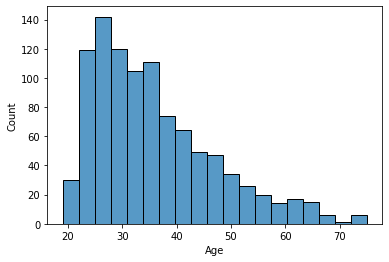

In [9]:
sns.histplot(df.Age)

Check the distributions of the variables

<AxesSubplot:xlabel='Age', ylabel='Density'>

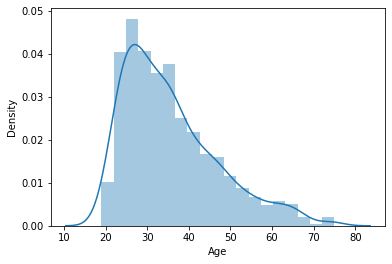

In [10]:
sns.distplot(df["Age"])

<AxesSubplot:xlabel='Credit amount', ylabel='Density'>

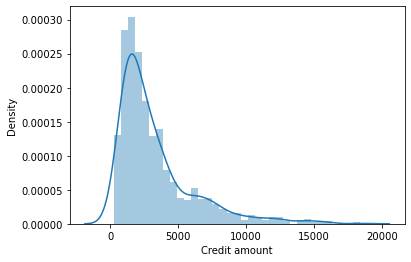

In [11]:
sns.distplot(df["Credit amount"])

<AxesSubplot:xlabel='Duration', ylabel='Density'>

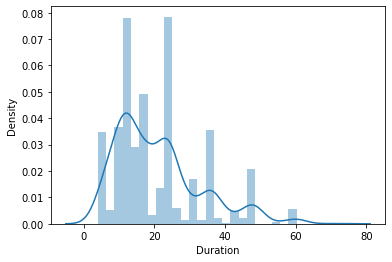

In [12]:
sns.distplot(df["Duration"])

Data is right-skewed. We will use log transform and check the distributions again.

### Outlier detection and log tansformation

In [13]:
cols_to_transform = ["Age","Credit amount", "Duration"]
data_to_transform = df.loc[:,cols_to_transform]

transformed_data = np.log(data_to_transform)

Before we transform the data, it would be good to look if there are outliers.

<AxesSubplot:>

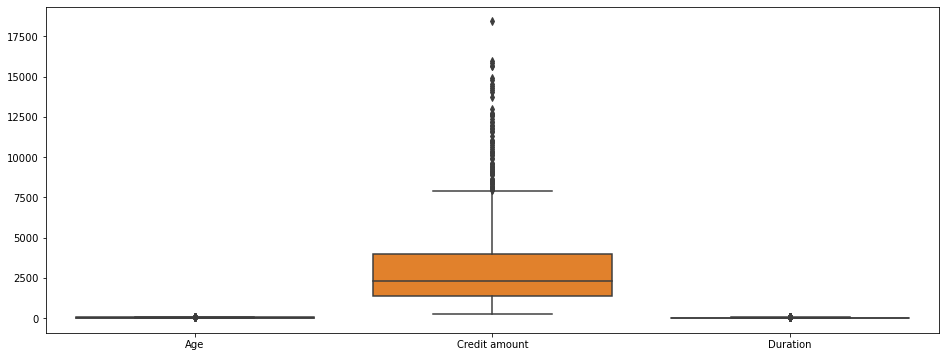

In [14]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=data_to_transform)

In [15]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# data_to_transform = remove_outlier(data_to_transform, "Credit amount")

In [16]:
#plt.figure(figsize=(16, 6))
#sns.boxplot(data=data_to_transform)

Even though there are outliers, I believe removing them would be counterproductive, because the data is probably correct.

<AxesSubplot:xlabel='Age', ylabel='Density'>

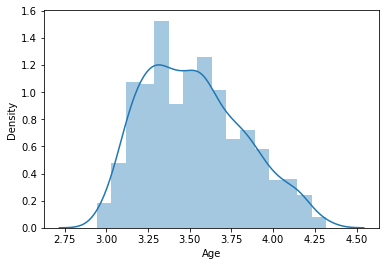

In [17]:
sns.distplot(transformed_data["Age"])

<AxesSubplot:xlabel='Credit amount', ylabel='Density'>

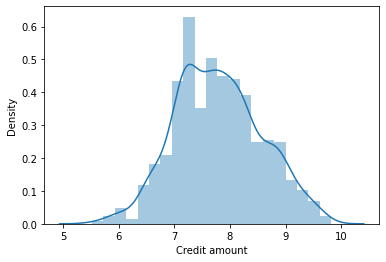

In [18]:
sns.distplot(transformed_data["Credit amount"])

<AxesSubplot:xlabel='Duration', ylabel='Density'>

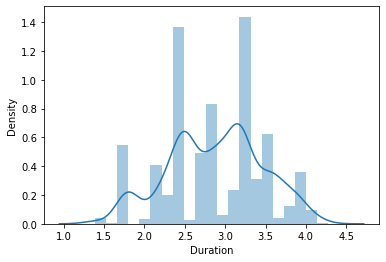

In [19]:
sns.distplot(transformed_data["Duration"])

In [20]:
df["Age"] = transformed_data["Age"]
df["Credit amount"] = transformed_data["Credit amount"]
df["Duration"] = transformed_data["Duration"]

We have log-transformed the data. The distribution is no longer right skewed - the data has been normalized. Let's take a look at the categorical variables.

### One-Hot Encoding

Let's one-hot encode the categorical variables. We have to use some kind of encoding to make sure the model accepts the data (xgboost won't work with String datatypes in the columns containing categorical data). This is also done to make sure there isn't any "hidden" relationship between values in categorical columns the model could see.

In [21]:
df.head(1)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,4.204693,male,2,own,none,little,7.063904,1.791759,radio/TV,good


In [22]:
categorical_cols = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'] 

In [23]:
df_one_hot_encoded = pd.get_dummies(df, columns = categorical_cols)

In [24]:
df_one_hot_encoded.head(1)

,Age,Credit amount,Duration,Risk,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,...,Checking account_none,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,4.204693,7.063904,1.791759,good,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Put the one-hot encoded variables back into our original dataframe.

In [25]:
df = df_one_hot_encoded

### Feature Scaling

Let's scale the continuous features using StandardScaler (since we already looked at the distributions and applied log transform, we know the data is not right skewed and resembles gaussian distribution, this seems like a good choice.

In [26]:
continuous_features = ['Age', 'Credit amount', 'Duration']
df_no_cat = df[continuous_features]
df_no_cat.head()

,Age,Credit amount,Duration
0,4.204693,7.063904,1.791759
1,3.091042,8.691315,3.871201
2,3.891820,7.647786,2.484907
3,3.806662,8.972337,3.737670
4,3.970292,8.490849,3.178054


In [27]:
df_scaled_no_cat = StandardScaler().fit_transform(df_no_cat)

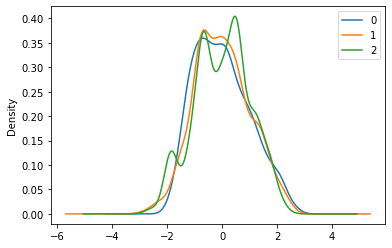

In [28]:
pd.DataFrame(df_scaled_no_cat).plot(kind='kde');

In [29]:
pd.DataFrame(df_scaled_no_cat).describe()

,0,1,2
count,1.000000e+03,1.000000e+03,1.000000e+03
mean,1.072920e-15,2.877698e-16,-4.618528e-17
std,1.000500e+00,1.000500e+00,1.000500e+00
min,-1.935487e+00,-2.921366e+00,-2.561606e+00
25%,-7.625864e-01,-7.337018e-01,-6.737898e-01
50%,-9.278474e-02,-5.100511e-02,2.294689e-02
75%,7.121696e-01,6.421928e-01,5.172894e-01
max,2.647496e+00,2.619193e+00,2.405105e+00


In [30]:
pd.DataFrame(df_scaled_no_cat).head()

,0,1,2
0,2.271006,-0.933901,-1.864869
1,-1.446152,1.163046,1.708369
2,1.226696,-0.181559,-0.673790
3,0.942455,1.525148,1.478913
4,1.488620,0.904743,0.517289


Looks like the data is scaled. Let's put the scaled data back to our original dataframe.

In [31]:
norm_df = pd.DataFrame(df_scaled_no_cat, columns=continuous_features)
df["Age"] = norm_df["Age"]
df["Credit amount"] = norm_df["Credit amount"]
df["Duration"] = norm_df["Duration"]

df.head(1)

,Age,Credit amount,Duration,Risk,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,...,Checking account_none,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,2.271006,-0.933901,-1.864869,good,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


### Elbow Method

We'll use the elbow method to find the optimal K value for the K-Means.

In [32]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_scaled_no_cat)
    Sum_of_squared_distances.append(km.inertia_)

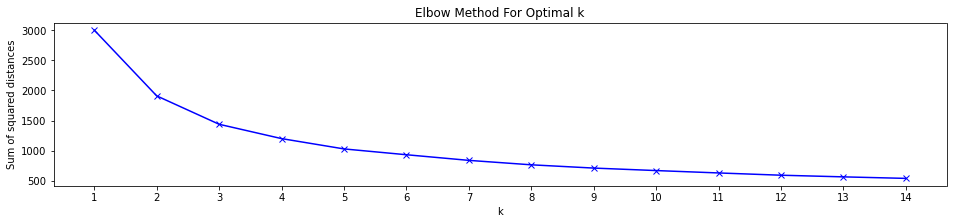

In [33]:
plt.figure(figsize=(16,3))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.show()

We can see that the optimal K value is 3.

### KMeans

We will use the number of clusters based on the elbow method (3) for our KMeans.

In [34]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
y_means = kmeans.fit(df_scaled_no_cat)

In [35]:
pd.Series(kmeans.labels_).value_counts()

2    375
1    367
0    258
dtype: int64

In [36]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=1000, n_init=100, random_state=0)
y_means = kmeans.fit(df_scaled_no_cat)
clusters = kmeans.fit_predict(df_scaled_no_cat)

### PCA

In [37]:
from sklearn.decomposition import PCA 

pca2 = PCA(n_components=2).fit(df_scaled_no_cat)
pca2d = pca2.transform(df_scaled_no_cat)

print("Explained variance is:", pca2.explained_variance_)
print("Explained variance ratio", pca2.explained_variance_ratio_)

Explained variance is: [1.62431022 1.00471706]
Explained variance ratio [0.5408953  0.33457078]


Explained variance: [1.62431022 1.00471706]
Explained variance ratio: [0.5408953  0.33457078]


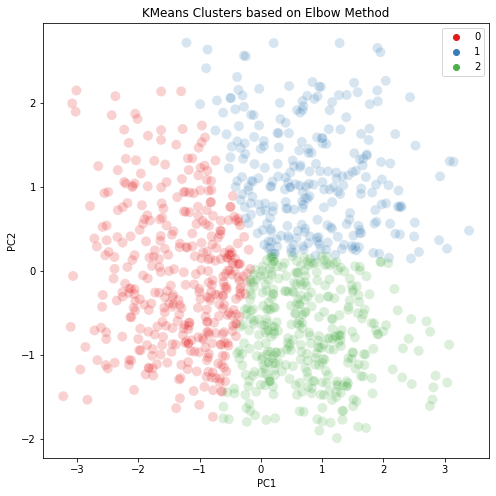

In [38]:
pca4 = PCA(n_components=2).fit(df_scaled_no_cat)
pca4d = pca4.transform(df_scaled_no_cat)

print("Explained variance:", pca4.explained_variance_)
print("Explained variance ratio:", pca4.explained_variance_ratio_)

plt.figure(figsize = (8,8))
sns.scatterplot(pca4d[:,0], pca4d[:,1], 
                hue=y_means.labels_, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters based on Elbow Method', fontsize=12)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

We can see the 3 clusters using PCA.

In [39]:
df_scaled_no_cat = pd.DataFrame(df_scaled_no_cat)

def pca_results(data, pca):

    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    return pd.concat([variance_ratios, components], axis = 1)
    

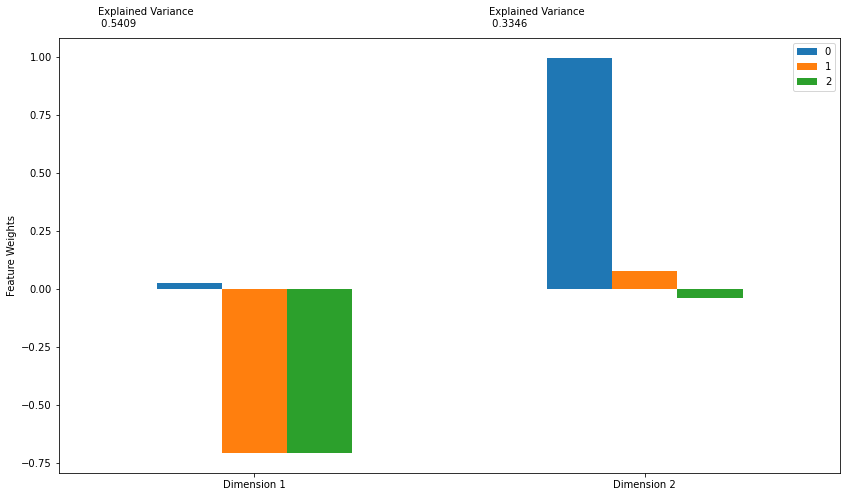

In [40]:
pca = PCA(n_components = 2, random_state=0)
pca.fit(df_scaled_no_cat)

pca_results = pca_results(df_scaled_no_cat, pca)

First 2 components explained variance: 0.8755 (87.6%)

Look at the clusters and their meaning

In [41]:
df_original = pd.read_csv("german_credit_data.csv")
df_clustered = df_original[['Age', 'Duration', 'Credit amount']]
df_clustered['cluster'] = clusters

In [42]:
df_clustered.groupby('cluster').mean()

,Age,Duration,Credit amount
cluster,,,
0,34.042667,32.224000,5665.384000
1,48.498099,13.859316,1970.349810
2,27.693370,14.292818,1736.290055


There are 3 clusters, we can see that there are three age groups - older, middle-aged and young customers.

### Training (XGBoost + RandomizedSearchCV)

In [43]:
encoder = preprocessing.LabelEncoder()
df['Risk'] = encoder.fit_transform(df['Risk'])
df.head(1)

,Age,Credit amount,Duration,Risk,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,...,Checking account_none,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,2.271006,-0.933901,-1.864869,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
df["Age"] = df_scaled_no_cat[0]
df["Credit amount"] = df_scaled_no_cat[1]
df["Duration"] = df_scaled_no_cat[2]

In [45]:
X = df.drop('Risk', 1)
y = df['Risk']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [47]:
classifier = xgboost.XGBClassifier(use_label_encoder=False)

params = {
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15, 20 ],
 "min_child_weight" : [ 1, 2, 3, 4, 5, 6, 7, 8, 9 ],
 "gamma": [ 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9],
 "eval_metric" : ["mlogloss"],
 "n_estimators": stats.randint(100, 2000),
 "learning_rate": stats.uniform(0.0001, 0.99),
 "subsample": stats.uniform(0.001, 0.99),
 "colsample_bytree": stats.uniform(0.001, 0.99),
}

rs_model=RandomizedSearchCV(classifier, param_distributions=params, n_iter=200, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
rs_model.fit(X_train,y_train)
rs_model.best_estimator_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.28992134555505056,
              enable_categorical=False, eval_metric='mlogloss', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.002336590371313266, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=904, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8062591008726809, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [48]:
model = rs_model.best_estimator_
kfold = KFold(n_splits=5)
results = cross_val_score(model, X, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
Accuracy = results.mean()*100

model = rs_model.best_estimator_
PW = cross_val_score(model, X, y, cv=kfold, scoring='precision_weighted')
Rscore = cross_val_score(model, X, y, cv=kfold, scoring='recall_weighted')

Recall = (round((Rscore.mean()*100),3))
Precision = (round((PW.mean()*100),3))

f1score=round(2*((Recall*Precision)/(Recall+Precision)),3)

print("Accuracy= %f, Recall=%f, Precision=%f, f1score=%f" % (Accuracy,Recall,Precision,f1score))


Accuracy: 72.70% (2.48%)
Accuracy= 72.700000, Recall=72.700000, Precision=73.059000, f1score=72.879000


### Evaluate model on test set

In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_model(name, model, features, labels):
    pred = model.predict(features)
    accuracy = round(accuracy_score(labels, pred), 3)
    precision = round(precision_score(labels, pred, average='micro'), 3)
    recall = round(recall_score(labels, pred, average='micro'), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {}'.format(name,accuracy,precision,recall))

In [50]:
evaluate_model("XGBClassifier using RandomizedSearchCV", model, X_test, y_test)

XGBClassifier using RandomizedSearchCV -- Accuracy: 0.74 / Precision: 0.74 / Recall: 0.74
